In [1]:
# Import necessary libaries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get

In [2]:
# Make a request
url = 'https://covid19.ncdc.gov.ng'
response = get(url, headers = {"Accept-Language": "en-US, en;q=0.5"})

In [3]:
print(response.text[:500])

<!DOCTYPE html>
<html lang="en">
<meta http-equiv="content-type" content="text/html;charset=UTF-8" />
<head>
<title>NCDC Coronavirus COVID-19 Microsite</title>
<!--[if lt IE 11]>
    	<script src="https://oss.maxcdn.com/libs/html5shiv/3.7.0/html5shiv.js"></script>
    	<script src="https://oss.maxcdn.com/libs/respond.js/1.4.2/respond.min.js"></script>
    	<![endif]-->
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=0, minimal-ui">
<meta


In [4]:
# Create a beautifulsoup object
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [5]:
# Locate table
covid_table = html_soup.find('div', class_ = 'table-responsive')

In [6]:
# Scrape table headers and pass into a list
table_heading = covid_table.thead.find_all('th')
headings = []
for th in table_heading:
    headings.append(th.text)
print(headings)

['States Affected', 'No. of Cases (Lab Confirmed)', 'No. of Cases (on admission)', 'No. Discharged', 'No. of Deaths']


In [7]:
# Scrape table rows and pass into a list
table_rows = []
for i in covid_table.tbody.find_all('tr'):
    table_rows.append(i.text.replace('\n', ' ').strip())
table_rows

['Lagos  8,407  6,848  1,436  123',
 'FCT  1,549  1,046  475  28',
 'Kano  1,184  422  712  50',
 'Rivers  866  480  356  30',
 'Oyo  860  569  282  9',
 'Edo  779  587  161  31',
 'Ogun  623  250  358  15',
 'Kaduna  552  256  286  10',
 'Delta  501  360  124  17',
 'Borno  466  82  353  31',
 'Gombe  451  211  226  14',
 'Bauchi  447  114  322  11',
 'Katsina  426  171  233  22',
 'Jigawa  317  120  191  6',
 'Ebonyi  234   97  137  0',
 'Abia  221  125  93  3',
 'Plateau  220  101  114  5',
 'Imo  205  181  21  3',
 'Nasarawa  184  90  88  6',
 'Kwara  180  52  122  6',
 'Bayelsa  155   117  29  9',
 'Sokoto  135  6  115  14',
 'Ondo  134  76  42  16',
 'Enugu  126  92  29  5',
 'Zamfara  76  0  71  5',
 'Kebbi  67  21  40  6',
 'Anambra  66  6  51  9',
 'Niger  66  31  33  2',
 'Akwa Ibom  65  23  40  2',
 'Yobe  56  3  45  8',
 'Osun  54  4  46  4',
 'Adamawa  42  1  37  4',
 'Benue  39  27  12  0',
 'Ekiti  34  4  28  2',
 'Taraba  18  8  10  0',
 'Kogi  3  3  0  0']

In [8]:
# Format table rows for dataframe
table_rows = [i.split() for i in table_rows]
table_rows

[['Lagos', '8,407', '6,848', '1,436', '123'],
 ['FCT', '1,549', '1,046', '475', '28'],
 ['Kano', '1,184', '422', '712', '50'],
 ['Rivers', '866', '480', '356', '30'],
 ['Oyo', '860', '569', '282', '9'],
 ['Edo', '779', '587', '161', '31'],
 ['Ogun', '623', '250', '358', '15'],
 ['Kaduna', '552', '256', '286', '10'],
 ['Delta', '501', '360', '124', '17'],
 ['Borno', '466', '82', '353', '31'],
 ['Gombe', '451', '211', '226', '14'],
 ['Bauchi', '447', '114', '322', '11'],
 ['Katsina', '426', '171', '233', '22'],
 ['Jigawa', '317', '120', '191', '6'],
 ['Ebonyi', '234', '97', '137', '0'],
 ['Abia', '221', '125', '93', '3'],
 ['Plateau', '220', '101', '114', '5'],
 ['Imo', '205', '181', '21', '3'],
 ['Nasarawa', '184', '90', '88', '6'],
 ['Kwara', '180', '52', '122', '6'],
 ['Bayelsa', '155', '117', '29', '9'],
 ['Sokoto', '135', '6', '115', '14'],
 ['Ondo', '134', '76', '42', '16'],
 ['Enugu', '126', '92', '29', '5'],
 ['Zamfara', '76', '0', '71', '5'],
 ['Kebbi', '67', '21', '40', '6'],
 

In [9]:
# Locate index position of Akwa Ibom
def get_index(strings, substr):
    for idx, string in enumerate(strings):
        if substr in string:
            break
    return idx

In [10]:
idx = get_index(table_rows, 'Akwa')

In [11]:
# Join 'Akwa' and 'Ibom'
del table_rows[idx][1]
table_rows[idx][0] = 'Akwa Ibom'
table_rows

[['Lagos', '8,407', '6,848', '1,436', '123'],
 ['FCT', '1,549', '1,046', '475', '28'],
 ['Kano', '1,184', '422', '712', '50'],
 ['Rivers', '866', '480', '356', '30'],
 ['Oyo', '860', '569', '282', '9'],
 ['Edo', '779', '587', '161', '31'],
 ['Ogun', '623', '250', '358', '15'],
 ['Kaduna', '552', '256', '286', '10'],
 ['Delta', '501', '360', '124', '17'],
 ['Borno', '466', '82', '353', '31'],
 ['Gombe', '451', '211', '226', '14'],
 ['Bauchi', '447', '114', '322', '11'],
 ['Katsina', '426', '171', '233', '22'],
 ['Jigawa', '317', '120', '191', '6'],
 ['Ebonyi', '234', '97', '137', '0'],
 ['Abia', '221', '125', '93', '3'],
 ['Plateau', '220', '101', '114', '5'],
 ['Imo', '205', '181', '21', '3'],
 ['Nasarawa', '184', '90', '88', '6'],
 ['Kwara', '180', '52', '122', '6'],
 ['Bayelsa', '155', '117', '29', '9'],
 ['Sokoto', '135', '6', '115', '14'],
 ['Ondo', '134', '76', '42', '16'],
 ['Enugu', '126', '92', '29', '5'],
 ['Zamfara', '76', '0', '71', '5'],
 ['Kebbi', '67', '21', '40', '6'],
 

In [12]:
# Pass table rows into data frame
data = pd.DataFrame(table_rows)
data.head()

,0,1,2,3,4
0,Lagos,"8,407","6,848","1,436",123
1,FCT,"1,549","1,046",475,28
2,Kano,"1,184",422,712,50
3,Rivers,866,480,356,30
4,Oyo,860,569,282,9


In [13]:
# Set table headers from headings list
data.columns = headings
data.head()

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,"8,407","6,848","1,436",123
1,FCT,"1,549","1,046",475,28
2,Kano,"1,184",422,712,50
3,Rivers,866,480,356,30
4,Oyo,860,569,282,9


In [14]:
# Remove all commas from columns
data.replace(',','', regex=True, inplace=True)

In [15]:
col = data.select_dtypes(object).columns[1:]
data[col] = data[col].apply(pd.to_numeric, errors='coerce')

In [16]:
data.dtypes

States Affected                 object
No. of Cases (Lab Confirmed)     int64
No. of Cases (on admission)      int64
No. Discharged                   int64
No. of Deaths                    int64
dtype: object

In [17]:
# Rename FCT to Abuja FCT
data.loc[data['States Affected'] == 'FCT', 'States Affected'] = 'Federal Capital Territory'

In [18]:
data.columns = ['States', 'Cases', 'Infected', 'Recoveries', 'Deaths']

In [19]:
data.head(3)

,States,Cases,Infected,Recoveries,Deaths
0,Lagos,8407,6848,1436,123
1,Federal Capital Territory,1549,1046,475,28
2,Kano,1184,422,712,50


In [20]:
# Export data frame to csv
data.to_csv('covid_nigeria.csv')

In [21]:
# Import libararies for map plotting
import geopandas as gpd
import geoplot as gpt
import matplotlib.pyplot as plt

In [22]:
# Load SHP files
shp = r'shapefile/Nigeria_Poly.shp'
shapefile = gpd.read_file(shp)

In [23]:
type(shapefile), shapefile.shape

(geopandas.geodataframe.GeoDataFrame, (37, 16))

In [24]:
shapefile.columns

Index(['id', 'country', 'name', 'enname', 'locname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2', 'geometry'],
      dtype='object')

In [25]:
# Drop unecassary columns
shapefile = shapefile.drop(['id', 'country', 'name', 'enname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2'], axis=1)

In [26]:
shapefile.columns = ['States', 'geometry']

In [27]:
shapefile.head(2)

,States,geometry
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7...."
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ..."


In [28]:
# Merge GeoDataFrame with covid statistics data
data = shapefile.merge(data, left_on='States', right_on='States')

In [29]:
type(data), data.shape

(geopandas.geodataframe.GeoDataFrame, (36, 6))

In [30]:
data.head(2)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",221,125,93,3
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",42,1,37,4


In [31]:
data.head(3)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",221,125,93,3
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",42,1,37,4
2,Akwa Ibom,"MULTIPOLYGON (((8.34338 4.60775, 8.34241 4.606...",65,23,40,2


In [32]:
# Define plot function
def visual(data, hue, cmap):
    fig, ax = plt.subplots(1, figsize=(38, 13))
    ax.set_title('Coronavirus {} by States'.format(hue), fontdict={'fontsize': '20', 'fontweight' : '3'})
    gpt.choropleth(data, hue=hue, cmap=cmap,
                   legend=True,edgecolor='lightgray', linewidth=0.1,
                   ax=ax,legend_kwargs={'aspect':30, 'label':'Counts', 'fraction':0.036, 'pad':0, 'orientation':'horizontal'});

    data['coords'] = data['geometry'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    for idx, row in data.iterrows():
        ax.annotate(s=row['States'], xy=row['coords'], color='black', fontsize=13, horizontalalignment='center')
        plt.savefig('{}.png'.format(hue.lower()), dpi=150)

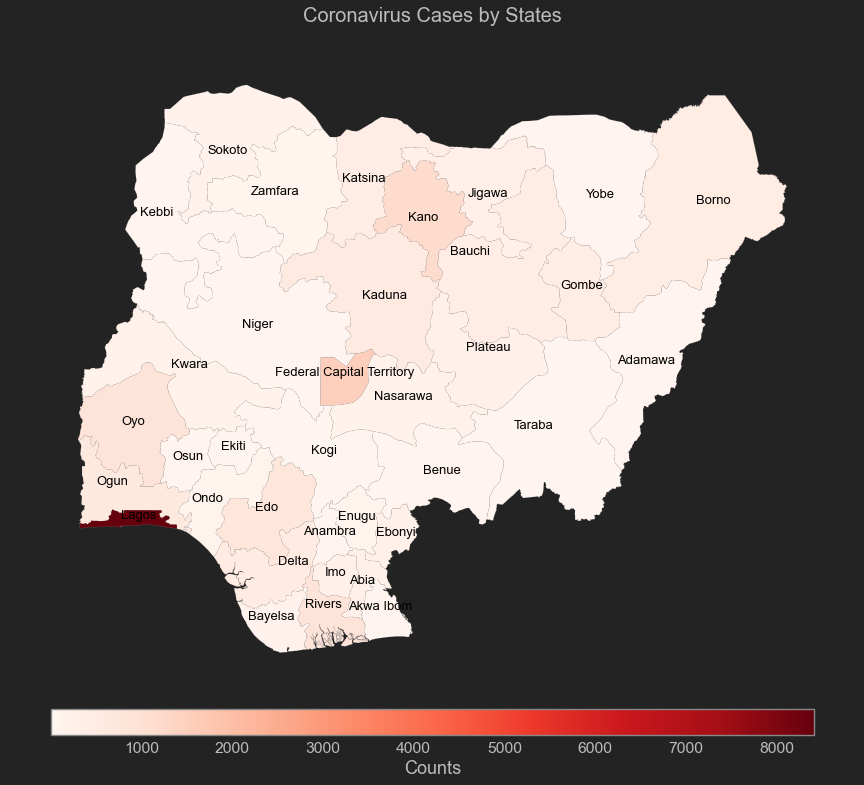

In [51]:
# Plot geomap for cases
visual(data, 'Cases', 'Reds')

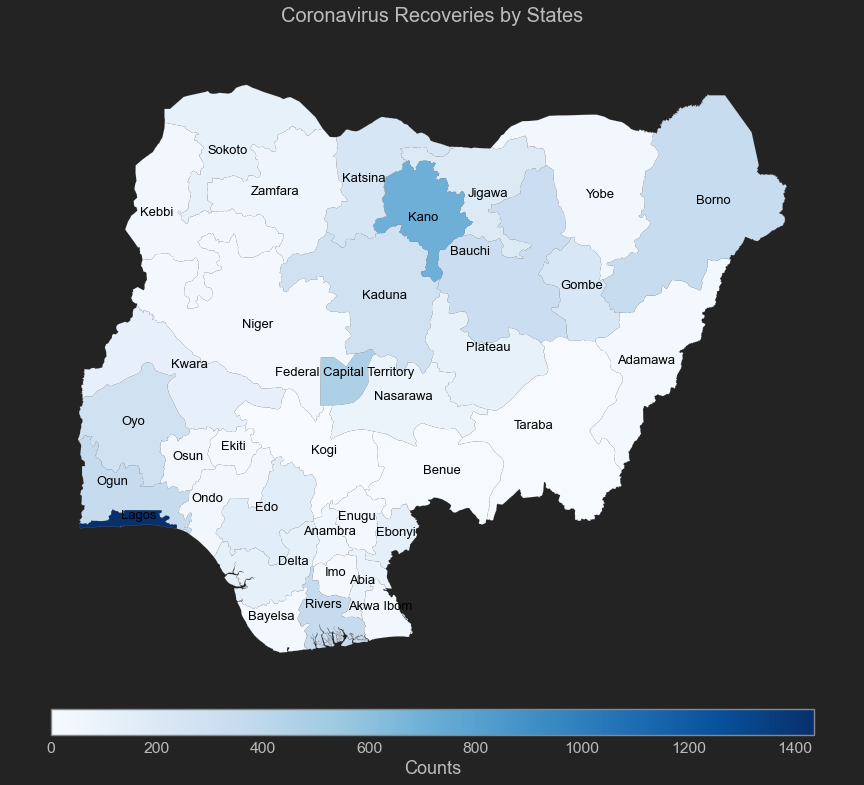

In [52]:
# Plot geomap for recoveries
visual(data, 'Recoveries', 'Blues')

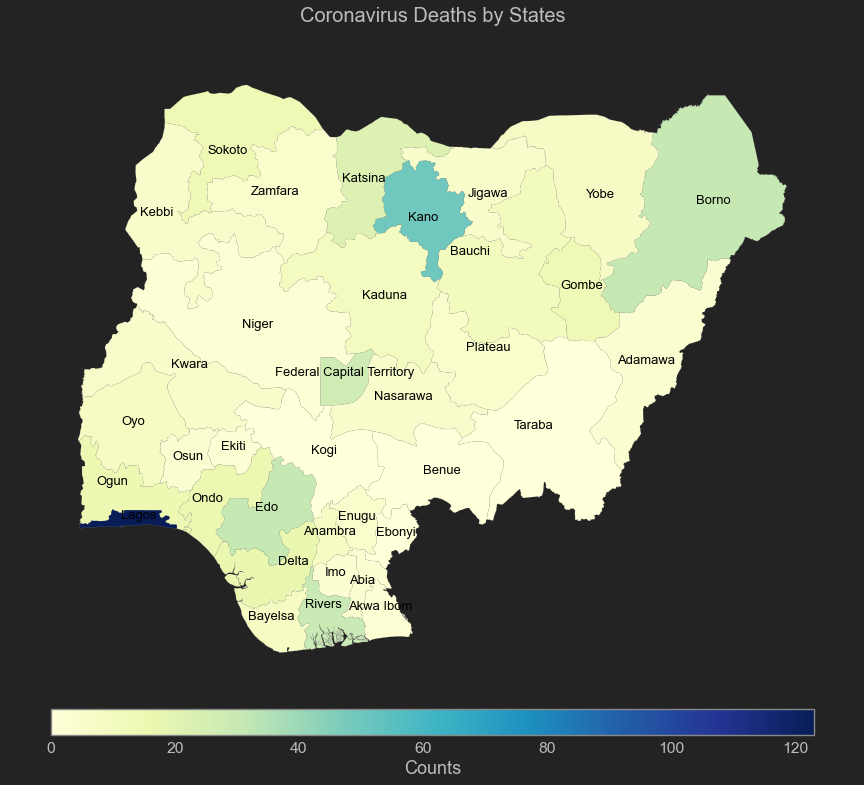

In [53]:
# Plot geomap for deaths
visual(data, 'Deaths', 'YlGnBu')

<h1 align='center'>Time Series Data</h1>

<p>Download data from Johns Hopkins University (JHU) Center for Systems Science and Engineering's (CSSE) GitHub repository</p>

In [33]:
cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [34]:
recovs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [35]:
deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [36]:
# Read data into data frame
df_cases = pd.read_csv(cases)
df_recovs = pd.read_csv(recovs)
df_deaths = pd.read_csv(deaths)

In [37]:
# Extract confirmed cases data for Nigeria
df_cases.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_cases.set_index('Country/Region', inplace=True)
df_cases = df_cases.loc['Nigeria']
df_cases = pd.DataFrame(df_cases)
df_cases.columns = ['Cases']
df_cases = df_cases.loc['2/28/20':]

In [38]:
# Extract recoveries data for Nigeria
df_recovs.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_recovs.set_index('Country/Region', inplace=True)
df_recovs = df_recovs.loc['Nigeria']
df_recovs = pd.DataFrame(df_recovs)
df_recovs.columns = ['Recoveries']
df_recovs = df_recovs.loc['2/28/20':]

In [39]:
# Extract death data for Nigeria
df_deaths.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_deaths.set_index('Country/Region', inplace=True)
df_deaths = df_deaths.loc['Nigeria']
df_deaths = pd.DataFrame(df_deaths)
df_deaths.columns = ['Deaths']
df_deaths = df_deaths.loc['2/28/20':]

In [40]:
# Merge cases, recoveriies and death data into one data frame
time_series = pd.concat([df_cases, df_recovs, df_deaths], axis=1, ignore_index=False)

In [41]:
# Rename columns
time_series.reset_index(inplace=True)
time_series.columns = ['Time', 'Cases', 'Recoveries', 'Deaths']

In [42]:
# Set time column type to datetime

#date = pd.date_range("1 22 2020", periods=time_series.shape[0], freq="D", name="date")
time_series['Time'] = pd.to_datetime(time_series['Time'], errors='coerce')

In [43]:
# Make time column index of the data frame
time_series.set_index('Time', inplace=True)

In [44]:
time_series = time_series.asfreq('D', method = 'ffill')

In [45]:
time_series.head()

,Cases,Recoveries,Deaths
Time,,,
2020-02-28,1,0,0
2020-02-29,1,0,0
2020-03-01,1,0,0
2020-03-02,1,0,0
2020-03-03,1,0,0


In [46]:
# Export time series data to csv
time_series.to_csv('time_series.csv')

In [47]:
# Import libraries for plotting
import seaborn as sns
from jupyterthemes import jtplot
import matplotlib.dates as mdates

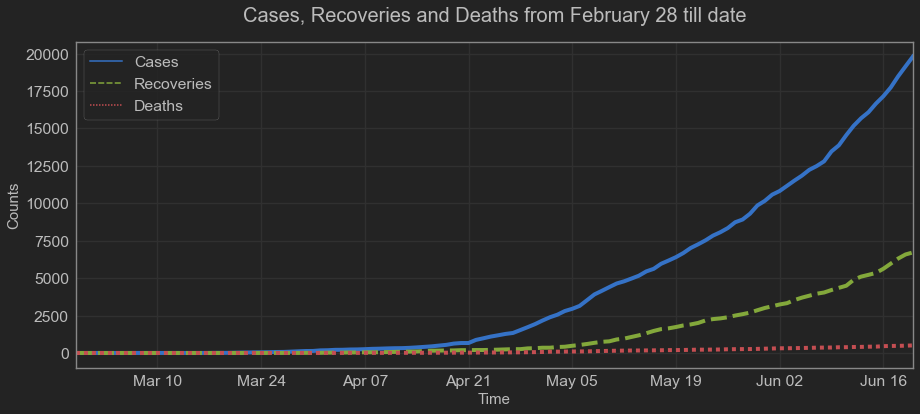

In [50]:
fig, ax = plt.subplots(figsize=(15, 6))
jtplot.style(theme='monokai', context='notebook', fscale=1.5, spines=True)
sns.lineplot(data=time_series, ax=ax, linewidth=4)
ax.set_title('Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('line-plot.png', dpi=150)

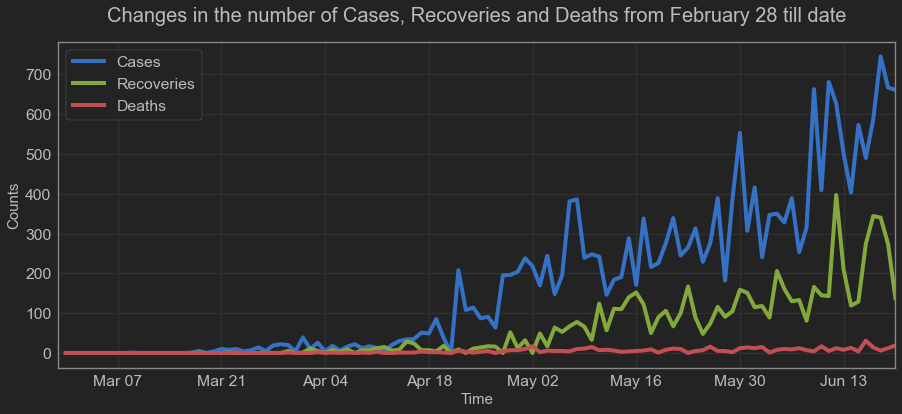

In [49]:
fig, ax = plt.subplots(figsize=(15, 6))
jtplot.style(theme='monokai', context='notebook', fscale=1.5, spines=True)
time_series.diff().plot(ax=ax, linewidth=4)
ax.set_title('Changes in the number of Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('time-lag.png', dpi=150)